# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
# IMPORTANT: RUN THIS CELL FOR EVERY EXERCISE

import glob
import pandas as pd
import numpy as np

DATA_FOLDER = "../../Arsalan/Homework 1/Data"

na_val=['?', 'NaN', 'NA', 'Na', 'na', 'nan', 'Nan']

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [2]:
import pandas as pd
import glob as glob
import datetime as dt
import calendar

'''The average number of new cases / deaths is computed through their cumulative amounts. The cumulative amount recorded on the 
last report of a month is subtracted to the cumulative amount on the first report of the same month. The number of deaths / new cases
thus obtained is then divided by the number of days between the two reports. 

One first approach to tackle this problem was to average over the variables representing the number of new cases and deaths 
since the last report. Hovewever, 'probable' new cases / deaths might be confirmed on the next report, thus counting twice if 
we were to aggregate them.

The first step is to parse the csv files from the 3 different countries into a unique dataset. For convenience, we keep track of 
each country through the column "Country". Note that the only NAs in the dataframe are those coming from the concatenation of the
single dataframes, i.e. a NA represents a non-existing column for that entry. This is ensured by the fact that NAs are replaced
with the value 'unknown' before concatenation.

We use this fact afterwards, when data cleaning takes place.
Data Cleaning consists of merging the "date" and "Date" columns, "Variable" with "Description" and "National" with "Totals" by
filling NA values. The old columns are removed from the dataframe. Columns for the month and the day are created to allow for 
queries on days and months. As far as the 'Description' field goes, newlines followed by a space are stripped out. This is 
because new lines would create unnecessary inconsistency.

Concerning average computation, we aggregate probable, suspected and confirmed cases. Moreover, the column "Totals" is the only 
used, i.e. we do not check that the total for that variable is consistent with the sum of values of the various regions. The
month of October was dropped from guinea's dataframe. This is because it only contained one report, thus
making it impossible to compute the average. December was dropped altogether from the dataframe, because for all countries 
several NAs were found in the relevant fields, thus resulting in artificial values for the average. December is anyway one
of the shortest recorded months in the dataset.
'''


'Load csv data for one country'
def read_country(country):
    files = glob.glob(DATA_FOLDER + "/ebola/" + country + "/*.csv")
    df = pd.concat((pd.read_csv(file) for file in files))
    df['Country'] = country
    return df.fillna("unknown")

'Load csv data for all countries'
def read_countries():
    df = read_country("guinea_data")
    df = df.append(read_country("sl_data"))
    df = df.append(read_country("liberia_data"))
    return df

'Make data consistent across the different countries'
def data_cleaning(df):
    df['Date'].fillna(df['date'], inplace=True)
    date = df['Date'].map(parseDate)
    df['Month'] = date.map(lambda x: x.month)
    df['Day'] = date.map(lambda x: x.day)
    df['Description'].fillna(df['Variable'], inplace=True)
    df['Description'].fillna(df['variable'], inplace=True)
    df['Description'] = df['Description'].str.replace('\\n ', '')
    df['Totals'].fillna(df['National'], inplace=True)
    del df['Date']
    del df['date']
    del df['Variable']
    del df['variable']
    del df['National']
    
'Parse Date to object. Various formats are possible'    
def parseDate(date):
    if ('/' in date):
        try :
            return dt.datetime.strptime(date, "%m/%d/%Y")
        except ValueError:
            return dt.datetime.strptime(date, "%m/%d/%y")
    return dt.datetime.strptime(date, "%Y-%m-%d")

'Aggregate given variables on a certain month and day'
def amount_on(month, day, variables):
    onDate = month[month['Day'] == day]
    amount = 0.0
    for var in variables:
        attr = onDate[onDate['Description'] == var]
        #print("Month ", month['Month'].iloc[0], ", Day", day, ":", attr[['Totals']], "desc:", var)
        amount += attr[['Totals']].iloc[0].astype(float)
    return amount

'''Compute the average of a month as the difference of given variables 
between the last and first day of the month'''
def month_avg(month, variables):
    last_day = month['Day'].max()
    first_day = month['Day'].min()
    tot = amount_on(month, last_day, variables) - amount_on(month, first_day, variables)
    return tot / (last_day - first_day)

'Compute the averages of all months for a given country'
def all_months_avgs(country, variables):
    return country.groupby(['Month']).apply(month_avg, variables)
    
'Compute average deaths and new cases for a given country'
def country_means(country, death_descriptors, new_cases_descriptors, country_label):
    res1 = all_months_avgs(country, death_descriptors)
    res1['Description'] = "Month average deaths"
    res2 = all_months_avgs(country, new_cases_descriptors)
    res2['Description'] = "Month average new cases"
    res = res2.append(res1)
    res['Country'] = country_label
    return res
        
df = read_countries()
data_cleaning(df)

guinea = df[df['Country'] == "guinea_data"]
guinea = guinea[guinea['Month'] < 10.0]
guinea_res = country_means(guinea, ["Total deaths (confirmed + probables + suspects)"],
                          ["Cumulative (confirmed + probable + suspects)"], "Guinea")
lib = df[df['Country'] == "liberia_data"]
lib = lib[lib['Month'] < 12.0]
lib_res = country_means(lib, ["Total death/s in confirmed, probable, suspected cases"],
                 ["Total suspected cases", "Total probable cases", "Total confirmed cases"], 
                  "Liberia")
sl = df[df['Country'] == "sl_data"]
sl = sl[sl['Month'] < 12.0]
sl_res = country_means(sl, ["death_confirmed", "death_suspected", "death_probable"],  
                       ["cum_suspected", "cum_probable", "cum_confirmed"], "Sierra Leone")
res = sl_res.append(lib_res).append(guinea_res)
#res['Month'] = res['Month'].apply(lambda x: calendar.month_abbr[x])
res

7,Totals,Description,Country
Month,,,
8,20.526316,Month average new cases,Sierra Leone
9,41.931034,Month average new cases,Sierra Leone
10,71.033333,Month average new cases,Sierra Leone
11,86.535714,Month average new cases,Sierra Leone
8,6.947368,Month average deaths,Sierra Leone
9,5.310345,Month average deaths,Sierra Leone
10,28.500000,Month average deaths,Sierra Leone
11,15.000000,Month average deaths,Sierra Leone
6,5.230769,Month average new cases,Liberia


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [3]:
'''
df corresponds to the data from the excel sheets MID1 to MID9 in a dataframe format
Every datasheet has a unique key (1 to 9) thus data has a double key: the sheet it comes from and a unique integer ID among its sheet
Therefore every line has a unique key in the form of a tuple (key1, key2)
We then rename columns NAME and VALUE

metadata comes from the metadata excel sheet in the form of a dataframe
We then simply, for every first key in df (so every sheet because the metadata is organized by excel sheet MID1 to MID9),
add the corresponding metadata (in 3 columns BARCODE, GROUP and SAMPLE)

We can finally print df!
'''

paths = glob.glob(DATA_FOLDER + "/microbiome/MID*.xls")
paths.sort()

data_array = [pd.read_excel(path, sheetname='Sheet 1', header=None, na_values=na_val, fill_value='unknown') for path in paths]
df = pd.concat(data_array, keys=[i+1 for i in range(len(data_array))])
df.rename(columns={0:'NAME', 1:'VALUE'}, inplace=True)

metadata = pd.read_excel(DATA_FOLDER + "/microbiome/metadata.xls", na_values=na_val, fill_value='unknown')
for item in metadata.items():
    df[item[0]] = 'unknown'
    for i in range(1,10):
        df.loc[i][item[0]] = item[1][i-1]
        
df

C:\Users\Michele\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


NAME  VALUE BARCODE  \
1 0    Archaea "Crenarchaeota" Thermoprotei Desulfuro...      7    MID1   
  1    Archaea "Crenarchaeota" Thermoprotei Desulfuro...      2    MID1   
  2    Archaea "Crenarchaeota" Thermoprotei Sulfoloba...      3    MID1   
  3    Archaea "Crenarchaeota" Thermoprotei Thermopro...      3    MID1   
  4    Archaea "Euryarchaeota" "Methanomicrobia" Meth...      7    MID1   
  5    Archaea "Euryarchaeota" "Methanomicrobia" Meth...      1    MID1   
  6    Archaea "Euryarchaeota" "Methanomicrobia" Meth...      1    MID1   
  7    Archaea "Euryarchaeota" Archaeoglobi Archaeogl...      1    MID1   
  8    Archaea "Euryarchaeota" Archaeoglobi Archaeogl...      1    MID1   
  9    Archaea "Euryarchaeota" Halobacteria Halobacte...      1    MID1   
  10   Archaea "Euryarchaeota" Halobacteria Halobacte...      4    MID1   
  11   Archaea "Euryarchaeota" Halobacteria Halobacte...      1    MID1   
  12   Archaea "Euryarchaeota" Halobacteria Halobacte...      2    MID1   
  13   Archaea "Euryarchaeota" Halobacteria Halobacte...      4    MID1   
  14   Archaea "Euryarchaeota" Methanococci Methanoco...      1    MID1   
  15   Archaea "Euryarchaeota" Methanopyri Methanopyr...     12    MID1   
  16   Archaea "Euryarchaeota" Thermoplasmata Thermop...      2    MID1   
  17   Bacteria "Actinobacteria" Actinobacteria Actin...      2    MID1   
  18   Bacteria "Actinobacteria" Actinobacteria Actin...      1    MID1   
  19   Bacteria "Actinobacteria" Actinobacteria Actin...      1    MID1   
  20   Bacteria "Actinobacteria" Actinobacteria Actin...      1    MID1   
  21   Bacteria "Actinobacteria" Actinobacteria Actin...      2    MID1   
  22   Bacteria "Actinobacteria" Actinobacteria Actin...     53    MID1   
  23   Bacteria "Actinobacteria" Actinobacteria Actin...      1    MID1   
  24   Bacteria "Actinobacteria" Actinobacteria Actin...      2    MID1   
  25   Bacteria "Actinobacteria" Actinobacteria Actin...      3    MID1   
  26   Bacteria "Actinobacteria" Actinobacteria Actin...      1    MID1   
  27   Bacteria "Actinobacteria" Actinobacteria Actin...     99    MID1   
  28   Bacteria "Actinobacteria" Actinobacteria Actin...     17    MID1   
  29   Bacteria "Actinobacteria" Actinobacteria Actin...      2    MID1   
...                                                  ...    ...     ...   
9 251  Bacteria "Proteobacteria" Gammaproteobacteria ...     10    MID9   
  252  Bacteria "Proteobacteria" Gammaproteobacteria ...      1    MID9   
  253  Bacteria "Proteobacteria" Gammaproteobacteria ...      1    MID9   
  254  Bacteria "Proteobacteria" Gammaproteobacteria ...      1    MID9   
  255  Bacteria "Proteobacteria" Gammaproteobacteria ...     12    MID9   
  256  Bacteria "Proteobacteria" Gammaproteobacteria ...      4    MID9   
  257  Bacteria "Proteobacteria" Gammaproteobacteria ...    805    MID9   
  258  Bacteria "Proteobacteria" Gammaproteobacteria ...    862    MID9   
  259  Bacteria "Proteobacteria" Gammaproteobacteria ...     12    MID9   
  260  Bacteria "Proteobacteria" Gammaproteobacteria ...   3534    MID9   
  261  Bacteria "Proteobacteria" Gammaproteobacteria ...      4    MID9   
  262  Bacteria "Proteobacteria" Gammaproteobacteria ...      1    MID9   
  263  Bacteria "Proteobacteria" Gammaproteobacteria ...     25    MID9   
  264  Bacteria "Proteobacteria" Gammaproteobacteria ...      2    MID9   
  265  Bacteria "Proteobacteria" Gammaproteobacteria ...      3    MID9   
  266  Bacteria "Proteobacteria" Gammaproteobacteria ...      2    MID9   
  267  Bacteria "Proteobacteria" Gammaproteobacteria ...      1    MID9   
  268  Bacteria "Proteobacteria" Gammaproteobacteria ...      3    MID9   
  269  Bacteria "Proteobacteria" Gammaproteobacteria ...      2    MID9   
  270  Bacteria "Proteobacteria" Gammaproteobacteria ...      1    MID9   
  271  Bacteria "Synergistetes" Synergistia Synergist...      3    MID9   
  272  Bacteria "Tenericutes" Mollicutes Anaeroplasma...      1    MID9   
  

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [4]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%pylab inline

from IPython.core.display import HTML
df = pd.read_excel(DATA_FOLDER + "/titanic.xls")
df.fillna('unknown')

from IPython.core.display import HTML
HTML(filename=DATA_FOLDER + '/titanic.html')

Populating the interactive namespace from numpy and matplotlib


Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [5]:
# Part 1

'''
'res' represents a dataframe that describes each column of the titanic dataset. It shows the type
for every column and it specifies a range of values. The categorical attributes are pclass, survived, sex, cabin, 
embarked, boat because they represent data that can only take fixed, discrete values such as Male/Female or class 1,2,3
for example.
This is unlike an attribute such as age which can be any value between the min and max (0.1667 and 80.0000 respectively)
The describe function computes values such as the mean, standard deviation, min, max and other features for a dataframe. 
We iterate over every column in our original dataframe and add a row in res containing type,min and max. Categorical data
will autmatically set min and max to NaN in the describe function
'''

df = pd.read_excel(DATA_FOLDER + "/titanic.xls")
res = pd.DataFrame(columns=['Type', 'Min', 'Max'])
for col in df.columns:
    desc = df[col].describe()
    if 'min' in desc.index:
        res.loc[col] = [desc.dtype, desc['min'], desc["max"]]
    else: 
        res.loc[col] = [desc.dtype, None, None]

print("Categorical data: pclass, survived, sex, cabin, embarked, boat")
df['pclass'] = pd.Categorical(df['pclass'])
df['survived'] = pd.Categorical(df['survived'])
df['sex'] = pd.Categorical(df['sex'])
df['cabin'] = pd.Categorical(df['cabin'].fillna("Unknown"))
df['embarked'] = pd.Categorical(df['embarked'])
df['boat'] = pd.Categorical(df['boat'])

#Dataframe before categorical data transformation
res

Categorical data: pclass, survived, sex, cabin, embarked, boat


,Type,Min,Max
pclass,float64,1.0000,3.0000
survived,float64,0.0000,1.0000
name,object,NaN,NaN
sex,object,NaN,NaN
age,float64,0.1667,80.0000
sibsp,float64,0.0000,8.0000
parch,float64,0.0000,9.0000
ticket,object,NaN,NaN
fare,float64,0.0000,512.3292
cabin,object,NaN,NaN


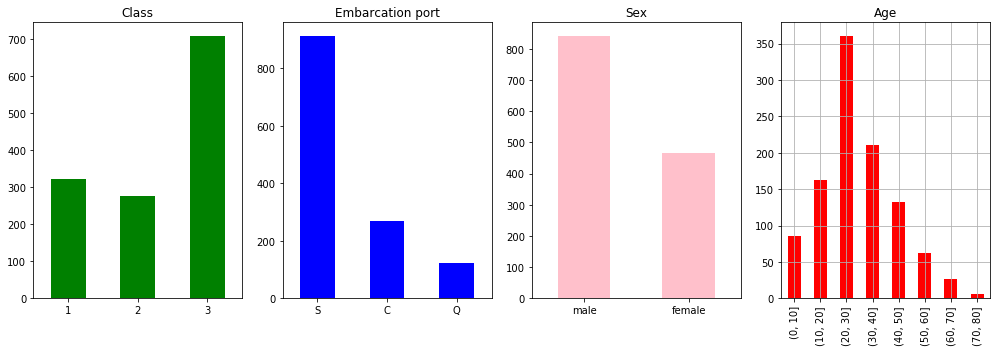

In [6]:
# Part 2

'''
Here, we use the value_counts function to count the occurences of a value in a Series. So for the Series pclass, we are counting
the amount of people that traveled in Class 1, 2 and 3. For choosing the size of age intervals, one has to make sure that they
aren't too big or small. If they're too big, there won't be as many bars and it won't really give an accurate representation of
the age distribution. If they're too small, we will have too many bars with very similar heights and it will be hard to make any
reasonable conclusions from it. 

From the graphs we can see that most people traveled in 3rd class which makes sense as there are more tickets in this category.
However there are more people travelling first class than second. One would typically assume that higher ticket prices meant 
less people buying that particular ticket as only the rich can afford the more expensive ones. A significant amount of people got
on from Southampton and this is because this was the first stop the titanic departed from. There were a lot more males travelling
than females and that the largest age range was people aged 20 to 30. 
'''

unused,subplots = plt.subplots(1,4, figsize=(14,5))

df['pclass'].value_counts(sort=False).plot(ax=subplots[0], kind='bar', title="Class", rot=0, color='green')
df['embarked'].value_counts(sort=True).plot(ax=subplots[1], kind='bar', title="Embarcation port", rot=0, color='blue')
df['sex'].value_counts(sort=True).plot(ax=subplots[2], kind='bar', title="Sex", rot=0, color='pink')
pd.cut(df['age'], [i for i in range(0, 90, 10)]).value_counts(sort=False).plot(ax=subplots[3], kind='bar', title="Age", color='red', grid=True)
plt.tight_layout()

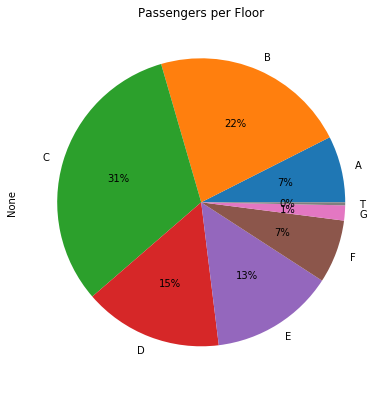

In [7]:
# Part 3

# The starting letter of the cabin is the floor. 
# Cabins with more than one letter such as "F G63" 
# are considered correct, since each floor is partitioned by letters as well
# (Source: "https://www.encyclopedia-titanica.org/").

'''
To find the amount of people in each cabin, we select the 'cabin' column and then apply a lambda function to each value
(a string) by returning the first letter of that string (for example if the value was 'A1', the string 'A' would be returned). 
This creates a new column where the value simply contains 1 character which represents the cabin floor. 
We then count the amount of people in each cabin by grouping them by the attribute 'floor'. 

An assumption we made here was that the floor of a cabin was determined by the first letter in it's id.
We drop any cabins with a value of 'U' as this represents an unknown. By counting the 'unknowns', however
we see that 77% of information is missing.
'''

df['floor'] = df['cabin'].map(lambda x: x[0])
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes((0,0,.5,1))
p_per_floor = df.groupby(['floor']).size().drop("U")
p_per_floor.plot(kind='pie', ax=ax, title="Passengers per Floor",  autopct='%i%%')

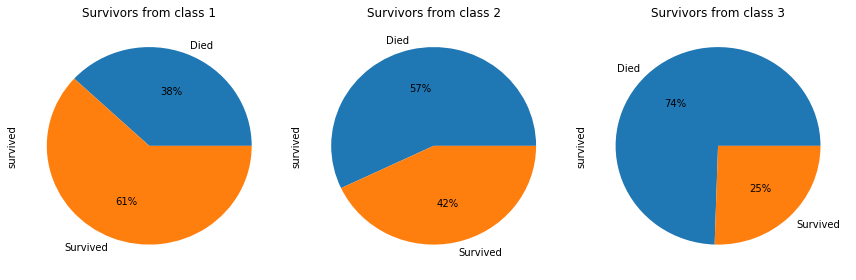

In [8]:
# Part 4

'''
Here we can see that passengers that rode 1st class had a much higher chance of survival. This survival rate 
decreases as the class gets lower. 
For i = 1,2,3 we do a query to find the dataframe such that all entries are passengers from class i. We then extract
the survived column, count the amount of people that survived and those that didn't and plot it in the pie chart. 
'''

unused, subplots = plt.subplots(1,3, figsize=(12,4))
for i in range(1,4):
    query = df.query('pclass == @i')['survived'].value_counts(sort=False)
    query.plot(ax=subplots[i-1], kind='pie', labels=['Died', 'Survived'], title=("Survivors from class " + str(i)), autopct='%i%%')
plt.tight_layout()

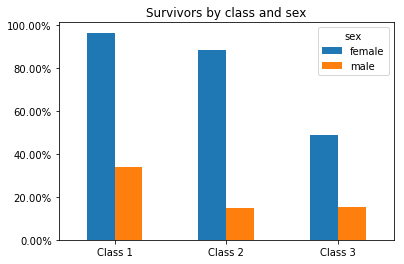

In [9]:
# Part 5
def class_by_sex(cls, data):
    passengers = cls.groupby(['sex']).size()
    survivors = cls[cls['survived'] == 1].groupby(['sex']).size()
    perc = survivors / passengers
    data["Class " + str(cls['pclass'].iloc[0])] = perc

data = pd.DataFrame(dtype=float)    
df.groupby(['pclass']).apply(class_by_sex, data)
data = data.transpose()
ax = data.plot(kind="bar", rot=0, title="Survivors by class and sex")
vals = ax.get_yticks()
res = ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

In [10]:
# Part 6
# The unique index is given by ('young or old', 'middle-aged') x ('male', 'female')

'''
We let young or old represent all people younger than 27 or older than 57 and we let middle-aged represent
people aged 27 to 57. This partitioning has an equal amount of people in each set (523 in each). We then calculate the survival
rates in these age ranges using the previously defined method class_by_sex to find survival rates according to sex and class.

The highest survival rates (greater than 85%) are found in females from class 1 or 2. The results seem to show that the age did not matter that 
much but this could be because the age interval is very large. It could be that survival rates vary amongst females depending 
on if they are a toddler, adolescent or adult. 
'''

#This method returns a dataframe with all of the survival rates (in percentages)
#For each gender and for each class it will compute a value based on age range
def generate_result(data_yo, data_ma):
    tuples = [("young or old", "male"),
          ("young or old", "female"),
          ("middle-aged", "male"),
         ("middle-aged", "female")]
    sex = ['male', 'female']
    classes = ['Class 1', 'Class 2', 'Class 3']
    data = pd.DataFrame(dtype=float, index=pd.MultiIndex.from_tuples(tuples))
    for s in sex:
        for cls in classes:
            data.loc[('young or old', s), cls] = data_yo.loc[s, cls]  
    for s in sex:
        for cls in classes:
            data.loc[('middle-aged', s), cls] = data_ma.loc[s, cls]
    return data * 100

data_yo = pd.DataFrame(dtype=float)
data_ma = pd.DataFrame(dtype=float)
yngs_and_olds = df[(df['age'] < 27) | (df['age'] > 57)]
middle_aged = df[(df['age'] >= 27) & (df['age'] <= 57)]
print("Size of youngs and olds: ", yngs_and_olds.shape[0])
print("Size of middle-aged: ", middle_aged.shape[0])

yngs_and_olds.groupby(['pclass']).apply(class_by_sex, data_yo)
middle_aged.groupby(['pclass']).apply(class_by_sex, data_ma)
generate_result(data_yo, data_ma)

Size of youngs and olds:  523
Size of middle-aged:  523


Class 1    Class 2    Class 3
young or old male    33.333333  23.943662  18.357488
             female  94.230769  89.795918  52.941176
middle-aged  male    35.779817   6.896552  14.788732
             female  97.530864  88.888889  36.000000